Pair1.xlsx


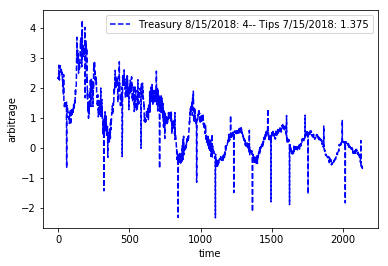

Pair2.xlsx


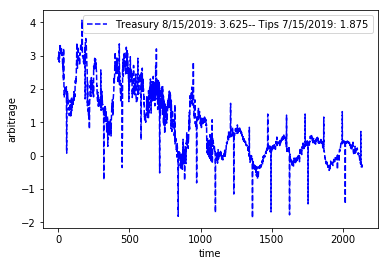

Pair3.xlsx


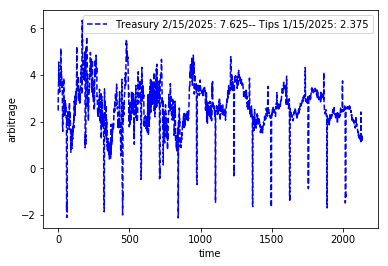

Pair4.xlsx


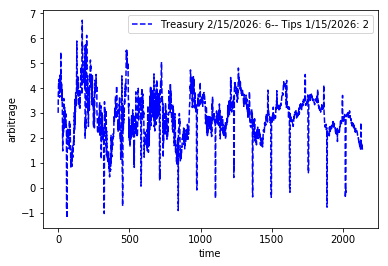

Pair5.xlsx


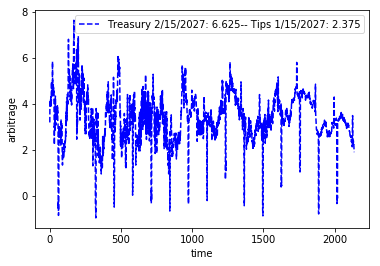

Pair6.xlsx


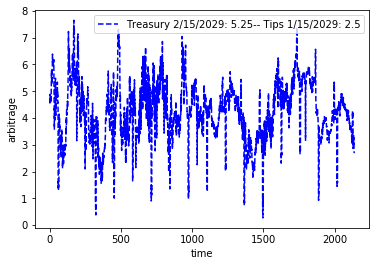

  Maturity Treasury Treasury Maturity Tips   Tips      Mean  \
0         8/15/2018        4     7/15/2018  1.375  0.729315   
1         8/15/2019    3.625     7/15/2019  1.875  0.927626   
2         2/15/2025    7.625     1/15/2025  2.375  2.595016   
3         2/15/2026        6     1/15/2026  2.000  2.858856   
4         2/15/2027    6.625     1/15/2027  2.375  3.370344   
5         2/15/2029     5.25     1/15/2029  2.500  4.234988   

   Standard Deviation       Max       Min  
0            0.936996  4.254365 -2.346860  
1            1.011866  4.062697 -1.863080  
2            1.046208  6.343331 -2.133014  
3            0.967234  6.722903 -1.200053  
4            1.072287  7.633353 -0.963910  
5            1.123089  7.650134  0.266664  


In [1]:
import math
import pandas as pd
import numpy as np
import scipy.optimize as optimize
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from datetime import datetime
from pandas import ExcelWriter
from pandas import ExcelFile


def disFactInpolDate(discFacs, maturityYears, interpolatedPeriods ):
    #print(" Enter: disFactInpolDate")
    discFactors =  list(discFacs)   
    periods = [x * 2 for x in maturityYears] 
    intPolStrips = interp1d(periods, discFactors, kind='cubic')
    discFact = intPolStrips(interpolatedPeriods)
    #print(" Exit: disFactInpolDate")
    return discFact


def swapInterPolate(valueData, maturityYears, interpolatedPeriods , tipsCouponRate):
    #print(" Enter: swapInterPolate")
    swapPeriods = [x * 2 for x in maturityYears]
    inflationSwap = []
    swapRates =  list(valueData)
    for i in range(len(swapPeriods)):
        inflationSwap.append(tipsCouponRate/2 * math.pow((1+swapRates[i]/200), swapPeriods[i]))
    intPolSwap = interp1d(swapPeriods, inflationSwap, kind='cubic')
    intPolSwapPrice = intPolSwap(interpolatedPeriods)
    #print(" Exit: swapInterPolate")
    return intPolSwapPrice

def funcReadSwapData():
    #print(" Enter: funcReadSwapData")
    df = pd.read_excel('swap.xlsx', sheet_name='swaps')
    matYrs = df.columns.tolist()
    listDates =list(df.index)  
    n =  len(listDates)
    drDict = {}
    for i in range(n):
        t = listDates[i]
        if(type(t)== str):
            drDict[t] = df.iloc[i,0:16]
        else:
            string = '{:%m/%d/%Y}'.format(t)
            drDict[string] = df.iloc[i,0:16]
    #print(" Exit: funcReadSwapData")
    return drDict, matYrs
    
def funcReadStripsData():
    #print(" Enter: funcReadStripsData")
    df = pd.read_excel('disFactors.xlsx', sheet_name='factors')
    maturityYears = df.columns.tolist()
    listDates =list(df.index)  
    n =  len(listDates)
    drDict = {}
    for i in range(n):
        t = listDates[i]
        if(type(t)== str):
            st = datetime.strptime(t, "%m/%d/%Y")
            string = '{:%m/%d/%Y}'.format(st)
            drDict[string] = df.iloc[i,0:15]
        else:
            string = '{:%m/%d/%Y}'.format(t)
            drDict[string] = df.iloc[i,0:15]
    #print(" Exit: funcReadStripsData")
    return drDict, maturityYears

def matchTreasuryTipsDate(name):
    #print(" Enter: matchTreasuryTipsDate")
    excelName = name+ ".xlsx"
    print(excelName)
    df = pd.read_excel(excelName, sheet_name='Sheet1')
    df.head()

    treasuryCouponRate = df.columns.tolist()[1]
    tipsCouponRate = df.columns.tolist()[3]

    trsMatur = df.iloc[0,1]
    tpsMatur = df.iloc[0,3]
    pairDictionTemp = {}
    pairDictionConcise = {}

    for i in range(2, len(df.iloc[:,1])):
        if(math.isnan(df.iloc[i,1])):
            print("Parsing treasury data")
        else:
            t = df.iloc[i,0]
            if(type(t)== str):
                st = datetime.strptime(t, "%m/%d/%Y")
                string = '{:%m/%d/%Y}'.format(st)
            else:
                string = '{:%m/%d/%Y}'.format(df.iloc[i,0])
            pairDictionTemp[string] = df.iloc[i,1]
        
    for i in range(2, len(df.iloc[:,3])):
   
        if(math.isnan(df.iloc[i,3]) ):
            print("Parsing tips data ")
        else:
            t = df.iloc[i,2]
            
            if(type(t)== str):
                st = datetime.strptime(t, "%m/%d/%Y")
                string = '{:%m/%d/%Y}'.format(st)
            else:
                string = '{:%m/%d/%Y}'.format(df.iloc[i,2])
                
            if string in pairDictionTemp:
                pairDictionConcise[string] = [pairDictionTemp[string], df.iloc[i,3]]
            else:
                print("tips treasury date mismatch")
    #print(" Exit: matchTreasuryTipsDate")
    return treasuryCouponRate, tipsCouponRate, trsMatur, tpsMatur, pairDictionConcise

def getIntPolPeriod(MaturityDate, StartDate):
    #print(" Enter: getIntPolPeriod")
    if(type(MaturityDate)== str):
        mat = datetime.strptime(MaturityDate, "%m/%d/%Y").timestamp()   
    else:
        mat = MaturityDate.timestamp()
    if(type(StartDate)== str):
        start = datetime.strptime(StartDate, "%m/%d/%Y").timestamp()   
    else:
        start = StartDate.timestamp()    
    counter = 0
    while(mat > start):
        counter = counter + 1
        mat =  mat - 15768000
    days =  int((mat+ 15768000- start)/86400)
    interpolatedPeriods = []
    for i in range(counter):
        interpolatedPeriods.append(days/180 + i)
    #print(" Exit: getIntPolPeriod")
    return interpolatedPeriods

def getSynBondPrice(newSwapRates, newDiscFactors,trsCouponRate, tipsCouponRate):
    #print(" Enter: getSynBondPrice")
    synBondPrice = 0
    for i in range(len(newSwapRates)):
        if i == (len(newSwapRates) -1 ):
            temp = (100+tipsCouponRate/2)* (newSwapRates[i]/(tipsCouponRate/2))
            val = (100 + trsCouponRate/2) -  temp
            synBondPrice = synBondPrice + val*newDiscFactors[i]
        else:
            val = trsCouponRate/2 -  newSwapRates[i]
            synBondPrice = synBondPrice + val*newDiscFactors[i]
    #print(" Exit: getSynBondPrice")
    return synBondPrice


def funMatMismatchYTM(price, matArr, coup, freq, guess):
    ytm_func = lambda y: sum([coup/((1+y/freq)**t) for t in matArr]) + 100 / ((1+y/freq)** matArr[-1]) - price    
    return optimize.newton(ytm_func, guess)

def calBondPriceYTM(coup, freq, matArr, ytm ):
    price = sum([coup/((1+ytm/freq)**t) for t in matArr]) + 100 / ((1+ytm/freq)** matArr[-1])
    return price

def main():
    
    stripsData, matStrips = funcReadStripsData()
    swapData, matSwaps = funcReadSwapData()
    #pairName = ['Pair1', 'Pair2', 'Pair3', 'Pair4', 'Pair5', 'Pair6', 'Pair7', 'Pair8', 'Pair9', 'Pair10', 'Pair11' , 'Pair12']
    pairName = ['Pair1', 'Pair2', 'Pair3', 'Pair4', 'Pair5', 'Pair6']
    finalFrame =  pd.DataFrame(columns=['Maturity Treasury', 'Treasury', 'Maturity Tips', 'Tips', 'Mean', 'Standard Deviation', 'Max', 'Min'])
           
    for k in range(len(pairName)):
        writer = ExcelWriter(pairName[k]+ "result.xlsx")
        trsCouponRate, tipsCouponRate, trsMatur, tpsMatur, matchDateTpsTrs = matchTreasuryTipsDate(pairName[k])
        printString = "Treasury "+ str(trsMatur)+": "+ str(trsCouponRate)+"-- Tips "+ str(tpsMatur)+": "+ str(tipsCouponRate)
        
        tinyArbitFrame = pd.DataFrame(columns = ['Date','Arbitrage'])
        arbitrageArray = []
        timeArr = []
        i = 1
       
        for key in matchDateTpsTrs:
            intPolTrs = getIntPolPeriod(trsMatur, key)
            intPolTps = getIntPolPeriod(tpsMatur, key)


            if key in stripsData and key in swapData:
                newDiscFactors = disFactInpolDate(stripsData[key], matStrips, intPolTps)
                newSwapRates = swapInterPolate(swapData[key], matSwaps, intPolTps, tipsCouponRate)

                synBondPrice = getSynBondPrice(newSwapRates, newDiscFactors,trsCouponRate, tipsCouponRate) + matchDateTpsTrs[key][1]
                ytm = funMatMismatchYTM(synBondPrice, intPolTps, trsCouponRate/2, 2, 0)
                if(ytm < 0.10):
                    synBondPriceYtm = calBondPriceYTM(trsCouponRate/2, 2, intPolTrs, ytm )
                    tinyArbitrage = matchDateTpsTrs[key][0] -synBondPriceYtm
                    #print(matchDateTpsTrs[key][0])
                    #print(key+" " + str(synBondPrice) + " "+ str(ytm) + " "+ str(synBondPriceYtm)+"arbit:" +str(tinyArbitrage ))
                    
                    arbitrageArray.append(tinyArbitrage)
                    tinyArbitFrame.loc[i] = [key, tinyArbitrage]
                    timeArr.append(i)
                    i = i+1    
        
        tinyArbitFrame.to_excel(writer,pairName[k],index=False)
        writer.save()

        plt.plot(timeArr, arbitrageArray, 'b--', label = printString)
        plt.ylabel('arbitrage')
        plt.xlabel('time')
        plt.legend()
        plt.show() 
            
        finalFrame.loc[k] = [trsMatur, trsCouponRate, tpsMatur,tipsCouponRate, np.mean(arbitrageArray), np.std(arbitrageArray), max(arbitrageArray), min(arbitrageArray)]

#     print(printString)       
#     print("Max:" + str(max(arbitrageArray)))  
#     print("Min:" + str(min(arbitrageArray)))
#     print("Mean:" + str(np.mean(arbitrageArray)))  
#     print("Standard Deviation:" + str(np.std(arbitrageArray)))

    print(finalFrame)
    finalFrame.to_html('finalTable.html')
     
        
if __name__=='__main__':
    main()

In [ ]:
 finalFrame = pd.DataFrame(columns=['Date', 'Treasury', 'Tips', 'Inflation Swaps', 'Strips', 'Total'])
    stripsSum = 0
    for i in range(0, totalPeriods+1):
        if i == 0 :
            finalFrame.loc[i] = [i,-treasuryPrice,-tipsPrice, 0, -7, 5 ]
        elif i == totalPeriods:
            tipsString  = str(100+tipsCouponRate/2)+'*I'+str(i)
            temp = (100+tipsCouponRate/2)* (intPolSwapPrice[i]/(tipsCouponRate/2))
            swapString = str(temp)+ '-'+ tipsString
            val = (100 + treasuryCouponRate/2) -  temp
            stripsSum = stripsSum + val*discFact[i-1]
            finalFrame.loc[i] = [i,100 + treasuryCouponRate/2 ,tipsString, swapString, val, 100+treasuryCouponRate/2 ]
        else:
            val = treasuryCouponRate/2 -  intPolSwapPrice[i]                  
            stripsSum = stripsSum + val*discFact[i-1]
            tipsString  = str(tipsCouponRate/2)+'*I'+str(i)
            swapString = str(intPolSwapPrice[i])+ '-'+ tipsString
            finalFrame.loc[i] = [i,treasuryCouponRate/2 ,tipsString, swapString, val, treasuryCouponRate/2 ]
    finalFrame.loc[0] = [0,-treasuryPrice,-tipsPrice, 0, -stripsSum,  -(stripsSum +tipsPrice)]
    

    
    
    
    

In [ ]:
import math
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from datetime import datetime



df = pd.read_excel('ProtoNew.xlsx', sheet_name='Sheet1')
df.head()

treasuryCouponRate = df.columns.tolist()[1]
tipsCouponRate = df.columns.tolist()[3]

trsMatur = df.iloc[0,1]
tpsMatur = df.iloc[0,3]
pairDictionTemp = {}
pairDictionConcise = {}
#print(type(df.iloc[2,0]))
for i in range(2, len(df.iloc[:,1])):
    string = '{:%m/%d/%Y}'.format(df.iloc[i,0])
    pairDictionTemp[string] = df.iloc[i,1]
for i in range(2, len(df.iloc[:,3])):
    if(math.isnan(df.iloc[i,3])):
        print("error in dictionary matching tips treasury")
    else:
        string = '{:%m/%d/%Y}'.format(df.iloc[i,2])
        pairDictionTemp[string] = df.iloc[i,1]
        if string in pairDictionTemp:
            pairDictionConcise[string] = [df.iloc[i,1], df.iloc[i,3]]

    

# for key in pairDictionConcise:
tpsMatur ='7/23/2004'
key = '12/30/2008'
mat = datetime.strptime(tpsMatur, "%m/%d/%Y")
string = '{:%m/%d/%Y}'.format(mat)

print(mat)
print(string)

# mat = datetime.strptime(tpsMatur, "%m/%d/%Y").timestamp()
# start = datetime.strptime(key, "%m/%d/%Y").timestamp()
# counter = 1
# while(mat > start):
#     mat =  mat - 15552000
#     counter = counter + 1 
# counter = counter - 1
# days =  int((start - mat)/86400)
# interpolatedPeriods = []
# for i in range(counter):
#     interpolatedPeriods.append(days/180 + i)
# print(interpolatedPeriods)   


    
    
    

    








In [53]:
import scipy.optimize as optimize


def bond_ytm(price, matArr, coup, freq, guess):
    ytm_func = lambda y: sum([coup/((1+y/freq)**t) for t in matArr]) + 100 / ((1+y/freq)** matArr[-1]) - price    
    return optimize.newton(ytm_func, guess)

if __name__ == "__main__":
    ytm = bond_ytm(103.461918448 ,[0.005555555555555556] ,1.625 ,2,0.002)
    print(ytm)

RuntimeError: Failed to converge after 50 iterations, value is (2.1942143566784647e+48+2.8578385939441172e+48j)

In [96]:
from datetime import datetime

def getIntPolPeriod(MaturityDate, StartDate):
    #print(" Enter: getIntPolPeriod")
    if(type(MaturityDate)== str):
        print(datetime.strptime(MaturityDate, "%m/%d/%Y"))
        mat = datetime.strptime(MaturityDate, "%m/%d/%Y").timestamp()   
    else:
        mat = MaturityDate.timestamp()
    if(type(StartDate)== str):
        start = datetime.strptime(StartDate, "%m/%d/%Y").timestamp()   
    else:
        start = StartDate.timestamp()    
    counter = 0
    print(mat)
    while(mat > start):
        counter = counter + 1
        mat =  mat - 15768000
    
    days1 = int((-mat+ start)/86400)

    days =  int((mat+ 15768000- start)/86400)
    print(days1)
    print(days)
    interpolatedPeriods = []
    for i in range(counter):
        interpolatedPeriods.append(days/180 + i)
    #print(" Exit: getIntPolPeriod")
    return interpolatedPeriods

getIntPolPeriod("1/15/2025", "7/28/2004")

2025-01-15 00:00:00
1736917200.0
6
176


[0.9777777777777777,
 1.9777777777777779,
 2.977777777777778,
 3.977777777777778,
 4.977777777777778,
 5.977777777777778,
 6.977777777777778,
 7.977777777777778,
 8.977777777777778,
 9.977777777777778,
 10.977777777777778,
 11.977777777777778,
 12.977777777777778,
 13.977777777777778,
 14.977777777777778,
 15.977777777777778,
 16.977777777777778,
 17.977777777777778,
 18.977777777777778,
 19.977777777777778,
 20.977777777777778,
 21.977777777777778,
 22.977777777777778,
 23.977777777777778,
 24.977777777777778,
 25.977777777777778,
 26.977777777777778,
 27.977777777777778,
 28.977777777777778,
 29.977777777777778,
 30.977777777777778,
 31.977777777777778,
 32.977777777777774,
 33.977777777777774,
 34.977777777777774,
 35.977777777777774,
 36.977777777777774,
 37.977777777777774,
 38.977777777777774,
 39.977777777777774,
 40.977777777777774]